In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import category_encoders as ce
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from matplotlib.colors import LogNorm,ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

%matplotlib inline

In [2]:
#data import
train_identity = pd.read_csv('../data/train_identity.csv')
train_transactions = pd.read_csv('../data/train_transaction.csv')
test_identity = pd.read_csv('../data/test_identity.csv')
test_transactions = pd.read_csv('../data/test_transaction.csv')

#split off y values
train_target = train_transactions['isFraud']
train_transactions = train_transactions.drop('isFraud',axis = 1)

# join the datasets
train_combined = train_transactions.set_index('TransactionID').join(train_identity.set_index('TransactionID'))
test_combined = test_transactions.set_index('TransactionID').join(test_identity.set_index('TransactionID'))

#split the data up
X_train, X_dev, y_train, y_dev = train_test_split(train_combined, train_target, test_size=0.10, random_state=42)

del train_transactions
del train_identity
del train_combined

In [3]:
def encode_categoricals(X,y,encoding_types = {}):
    '''
    Encodes defined columns according to encoding_types dict
    X: input features, should be able to handle pandas df or np array
    y: ouput labels, only used for types of cat encoders that require it, np array or pandas series/df slice
    #uid: unique id for joining things back together
    encoding_types: dictionary defining which encoding types to use for which columns
    See categorical encoder for types of encoders. Use categorical encoder method name as string for keys in dict.
    http://contrib.scikit-learn.org/categorical-encoding/
    Example encoding_types dict:
    {'OneHotEncoder': ['DeviceType','id_12','id_15'], 'BinaryEncoder': ['id_18', 'id_24']}
    '''
    for encoding_type, columns in encoding_types.items():
        if encoding_type == 'BackwardDifferenceEncoder' :
            #the mean of the dependent variable for one level of the categoricalvariable is compared to the
            #mean of the dependent variable for the prior adjacent level.
            encoder = ce.BackwardDifferenceEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'BaseNEncoder':
            encoder = ce.BaseNEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'BinaryEncoder':
            #first the categories are encoded asordinal, then those integers are converted into binary code,
            #then the digits from that binary string are split into separate columns
            encoder = ce.BinaryEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'CatBoostEncoder':
            encoder = ce.CatBoostEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'HashingEncoder':
            encoder = ce.HashingEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'HelmertEncoder':
            #Helmert Coding compares each level of a categorical variable to the mean of the subsequent levels
            encoder = ce.HelmertEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'JamesSteinEncoder':
            #not useful for binary classification, see doc string in source:
            #https://github.com/scikit-learn-contrib/categorical-encoding/blob/master/category_encoders/james_stein.py
            encoder = ce.JamesSteinEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'LeaveOneOutEncoder':
            encoder = ce.LeaveOneOutEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'MEstimateEncoder':
            #simplified target encoder. See source:
            #https://github.com/scikit-learn-contrib/categorical-encoding/blob/master/category_encoders/m_estimate.py
            encoder = ce.MEstimateEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'OneHotEncoder':
            #useful for nominal categorical variables with low cardinality (few unique categories)
            encoder = ce.OneHotEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'OrdinalEncoder':
            #an integer is assigned to each category, provided the number of existing categories are known.
            #It does not add any newcolumns to the data, but implies an order to the variable that may not 
            #actually exist
            encoder = ce.OrdinalEncoder(cols=columns, return_df=True)
       
        elif encoding_type == 'SumEncoder':
            #Sum coding compares the mean of the dependent variable for a given level to the overall mean of
            #the dependent variable over all the levels.
            encoder = ce.SumEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'PolynomialEncoder':
            #Looks for polynomial trends in the categorical variable. Should only be used with an ordinal variable
            #where the levels are equally spaced
            encoder = ce.PolynomialEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'TargetEncoder':
            encoder = ce.TargetEncoder(cols=columns, return_df=True)
        
        elif encoding_type == 'WOEEncoder':
            #Combine categories with similar weight-of-evidence and then create new categories of an 
            #independent variable with continuous weight-of-evidence values.
            encoder = ce.WOEEncoder(cols=columns, return_df=True)
        
        else:
            raise TypeError('Invalid encoder selected. See Categorical Encoder docs:\nhttp://contrib.scikit-learn.org/categorical-encoding/')
            
        encoder.fit(X, y)
        X = encoder.transform(X)
        
    return X

In [4]:
# --Identity Categorical Variables--
#Can be OHE:
# - DeviceType -> 2 cols (140810 values)
# - id_12 -> 2 cols (144233 values)
# - id_15 -> 3 cols (140985 values)
# - id_16 -> 2 cols (129340 values)
# - id_23 -> 3 cols (5169 values)
# - id_27 -> 2 cols (5169 values)
# - id_28 -> 2 cols (140978 values)
# - id_29 -> 2 cols (140978 values)
# - id_32 -> 4 cols (77586 values)
# - id_34 -> 4 cols (77805 values)
# - id_35 -> 2 cols (140985 values)
# - id_36 -> 2 cols (140985 values)
# - id_37 -> 2 cols (140985 values)
# - id_38 -> 2 cols (140985 values)

#might be able to be cleaned for ohe, investigate:
# - DeviceInfo 1786 cols if not ohe (118666 values)
# - id_30 75 cols, appears to be OS (77565 values)
# - id_31 130 cols, appears to be browser (140282 values)
# - id_33 261 cols, appears to be resolution (73289 values), may be able to turn into ratio?

#Will not OHE
# - id_13: numeric min 10, max 64, all ints, 55 vals inc null (127320 values)
# - id_14: numeric min -660, max 720, all ints, 26 vals inc null (80044 values)
# - id_17: numeric min 100, max 229, all ints, 105 vals inc null (139369 values)
# - id_18: numeric min 10, max 29, all ints, 19 vals inc null (45113 values)
# - id_19: numeric min 100, max 671, all ints, 523 vals inc null (139318 values)
# - id_20: numeric min 100, max 661, all ints, 395 vals inc null (139261 values)
# - id_21: numeric min 100, max 854, all ints, 491 vals inc null (5159 values)
# - id_22: numeric min 10, max 44, all ints, 26 vals inc null (5169 values)
# - id_24: numeric min 11, max 26, all ints, 13 vals inc null (4747 values)
# - id_25: numeric min 100, max 548, all ints, 342 vals inc null (5132 values)
# - id_26: numeric min 100, max 216, all ints, 96 vals inc null (5163 values)

# --Transaction Categorical Variables--
# Can OHE 
#'ProductCD','card4','card6','M1','M2','M3','M4','M5','M6','M7','M8','M9'

# Cannot OHE (too much cardinality)
# 'P_emaildomain','R_emaildomain','card1','card2','card3','card5','addr1','addr2'

# We want to minimize info loss so not using encoders than will result in that.
# Cannot assume ordinality  or interval equality for categories not knowing the meaning of the categories
# How do encoders like Weight of Evidence work if we don't have labels for test data? -> assumed value like 0.5

#Per this flow chart we should use a Leave One Out If we want to control for outliers. This is for the columns that we cannot OHE.

#let's do that for now and assess performance. Will probably need to do some kind of cross validation to find optimal values for sigma
encoding_types_transaction = {'OneHotEncoder':['ProductCD','card4','card6','M1','M2',\
                                               'M3','M4','M5','M6','M7','M8','M9'],\
                              'LeaveOneOutEncoder': ['P_emaildomain','R_emaildomain','card1',\
                                                     'card2','card3','card5','addr1','addr2']}


encoding_types_identity = {'OneHotEncoder': ['DeviceType','id_12','id_15','id_16','id_23','id_27','id_28',\
                                             'id_29','id_32','id_34','id_35','id_36','id_37','id_38'],\
                           'LeaveOneOutEncoder': ['DeviceInfo','id_13','id_14','id_17','id_18','id_19',\
                                                  'id_20','id_21','id_22','id_24','id_25','id_26','id_30',\
                                                  'id_31','id_33']}

#combined the encoding types into one dict because we are joining the data
train_encoding_types = {'OneHotEncoder': encoding_types_transaction['OneHotEncoder'] + encoding_types_identity['OneHotEncoder'],\
                           'LeaveOneOutEncoder' : encoding_types_transaction['LeaveOneOutEncoder'] + encoding_types_identity['LeaveOneOutEncoder']}

dev_encoding_types = {'OneHotEncoder': encoding_types_transaction['OneHotEncoder'] + encoding_types_identity['OneHotEncoder']}

#drop datetime and id because it adds const variance
X_train = X_train.drop(['TransactionDT'],axis = 1)
X_dev = X_dev.drop(['TransactionDT'],axis = 1)


X_train = clean_up(X_train,y_train,train_encoding_types)

# need to fill in 0.5 for all LOO encoded columns in dev set
X_dev[train_encoding_types['LeaveOneOutEncoder']] = 0.5

X_dev = enc(X_dev,None,dev_encoding_types)



In [5]:
#Need to remove columns that don't exist in test/dev data
shared_cols = X_train.columns & X_dev.columns

X_train = X_train[shared_cols]
X_dev = X_dev[shared_cols]

In [6]:
print(shared_cols)

Index(['TransactionAmt', 'ProductCD_1', 'ProductCD_2', 'ProductCD_3',
       'ProductCD_4', 'ProductCD_5', 'card1', 'card2', 'card3', 'card4_1',
       ...
       'id_37_1', 'id_37_2', 'id_37_3', 'id_38_1', 'id_38_2', 'id_38_3',
       'DeviceType_1', 'DeviceType_2', 'DeviceType_3', 'DeviceInfo'],
      dtype='object', length=495)


In [6]:
#impute null values
imputer = SimpleImputer(copy=False,strategy = 'constant', fill_value = 0)
X_train = imputer.fit_transform(X_train)
imputer = SimpleImputer(copy=False,strategy = 'constant', fill_value = 0)
X_dev = imputer.fit_transform(X_dev)

#normalize
#transformer = Normalizer(copy=False)
transformer = StandardScaler(copy = False)
X_train= transformer.fit_transform(X_train)
transformer = StandardScaler(copy = False)
X_dev = transformer.fit_transform(X_dev)

In [7]:
#use smote
smote = SMOTE(random_state = 42,sampling_strategy = 0.3, n_jobs = -1)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(X_train_res.shape,y_train_res.shape)
del X_train, y_train

(666811, 495) (666811,)


In [16]:
#initialize PCA
pca = PCA()
#fit PCA to training data
pca_data = pca.fit(X_train_res)



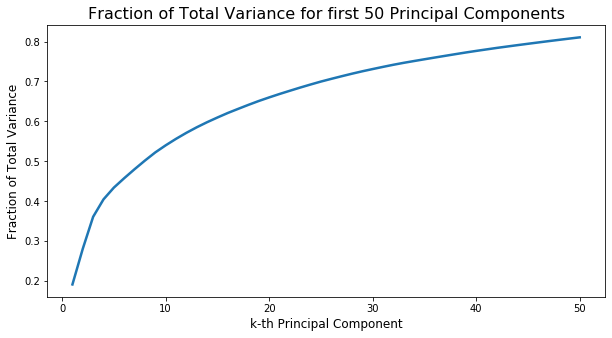

In [17]:
#get num of components
nc = pca.components_.shape[0]
    
#generate k values
ks = np.linspace(1,nc,num=nc)
    
#initialize a list to hold cumulate explained variance ratios
evrs = []
ev = 0 #cumulative explained variance
#loop over explained variance ratios for each component of the data
for evr in pca.explained_variance_ratio_:
    #add to cumulative explained variance
    ev += evr
    #add the current cumulatove explained variance to the list
    evrs.append(ev)
    
    
#plot the results.
fig = plt.figure(figsize = (10,5))
plt.plot(ks[:50],evrs[:50],linewidth=2.5)
plt.title('Fraction of Total Variance for first 50 Principal Components',fontsize = 16)
plt.xlabel('k-th Principal Component',fontsize = 12)    
plt.ylabel('Fraction of Total Variance',fontsize = 12)
plt.show()

In [18]:
#initialize PCA with two principal components
pca = PCA(n_components=2)
#perform PCA on the traing data 
pca_data = pca.fit_transform(X_train_res)
#create individual arrays for X and Y principal components
X = np.array([i[0] for i in pca_data])
Y = np.array([i[1] for i in pca_data])
 


In [25]:
print(y_train.values)

[0 0 0 ... 0 0 1]


In [19]:
y_train = np.array(y_train_res)

# split the df into positive and negative cases
fraud_indices = [True if y_train[i] == 1 else False for i in range(len(y_train))]
not_fraud_indices = [True if y_train[i] == 0 else False for i in range(len(y_train))]

X_fraud = X[fraud_indices]
X_not_fraud = X[not_fraud_indices]
Y_fraud = Y[fraud_indices]
Y_not_fraud = Y[not_fraud_indices]


#generate a color map from the labels. Positive (fraud cases) are mapped as blue and negative (non-fraud)
#cases are mapped as red.
colors = ['blue' if i == 1 else 'red' for i in y_train]
 



# look at cut point for floor of chart.
# find number of points above and below that cut point. Maybe this is related to the imputation and lack of
# identity values for 75% of the dataset.

In [37]:
print(y_train.shape,X_train.shape)

(531486,) (531486, 495)


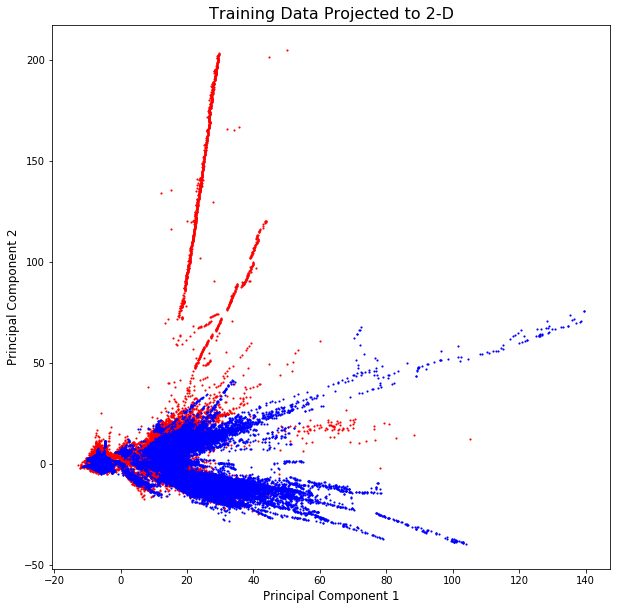

In [20]:
#plot the data
fig = plt.figure(figsize = (10,10))
plt.scatter(X_not_fraud,Y_not_fraud, c = 'red',marker='.',s=5)
plt.scatter(X_fraud,Y_fraud, c = 'blue',marker='.',s=5)



plt.title('Training Data Projected to 2-D',fontsize = 16)
plt.xlabel('Principal Component 1',fontsize = 12)
plt.ylabel('Principal Component 2',fontsize = 12)
plt.show()

In [45]:
print(X_train_res.shape)

(769398, 495)


In [ ]:
#plot the data
fig = plt.figure(figsize = (10,10))
plt.scatter(X_not_fraud,Y_not_fraud, c = 'red',marker='.',s=5)
plt.scatter(X_fraud,Y_fraud, c = 'blue',marker='.',s=5)

plt.title('Training Data Projected to 2-D - Limited PC2',fontsize = 16)
plt.xlabel('Principal Component 1',fontsize = 12)
plt.ylabel('Principal Component 2',fontsize = 12)
#plt.ylim(-15000,80000)
plt.show()

In [18]:
def calc_under_over(data,threshold = 0):
    total = len(data)
    under = np.sum([1 if i <= threshold else 0 for i in data])
    over = np.sum([1 if i > threshold else 0 for i in data])
    perc_under = under/total
    perc_over = over/total
    return perc_under, perc_over

In [19]:
t = 0
print('Principal Component 2 Threshold: %i'%t)
print('Fraud Under: %3f | Fraud Over: %3f'%calc_under_over(X_fraud,t))
print('Not Fraud Under: %3f | Not Fraud Over: %3f'%calc_under_over(X_not_fraud,t))
print('Total Under: %3f | Total Over: %3f'%calc_under_over(X,t))

Principal Component 2 Threshold: 0
Fraud Under: 0.556988 | Fraud Over: 0.443012
Not Fraud Under: 0.824046 | Not Fraud Over: 0.175954
Total Under: 0.735027 | Total Over: 0.264973


In [8]:
clf = LogisticRegression(penalty = 'l2', tol = 0.01, random_state=42, solver = 'saga').fit(X_train_res, y_train_res)
predictions = clf.predict(X_dev)
probs = clf.predict_proba(X_dev)
roc_auc = metrics.roc_auc_score(y_dev,[p[1] for p in probs])
print('AUC ROC: %.3f'%roc_auc)
print(metrics.confusion_matrix(y_dev,predictions, labels = [0,1]))
print(metrics.classification_report(y_dev,predictions))

AUC ROC: 0.717
[[56875    70]
 [ 1808   301]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     56945
           1       0.81      0.14      0.24      2109

    accuracy                           0.97     59054
   macro avg       0.89      0.57      0.61     59054
weighted avg       0.96      0.97      0.96     59054



In [9]:

clf = RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=100).fit(X_train_res, y_train_res)
predictions = clf.predict(X_dev)
probs = clf.predict_proba(X_dev)
roc_auc = metrics.roc_auc_score(y_dev,[p[1] for p in probs])
print('AUC ROC: %.3f'%roc_auc)
print(metrics.confusion_matrix(y_dev,predictions, labels = [0,1]))
print(metrics.classification_report(y_dev,predictions))

AUC ROC: 0.687
[[14959 41986]
 [   98  2011]]
              precision    recall  f1-score   support

           0       0.99      0.26      0.42     56945
           1       0.05      0.95      0.09      2109

    accuracy                           0.29     59054
   macro avg       0.52      0.61      0.25     59054
weighted avg       0.96      0.29      0.40     59054



In [8]:
clf = XGBClassifier(n_jobs = -1).fit(X_train_res, y_train_res)
predictions = clf.predict(X_dev)
probs = clf.predict_proba(X_dev)
roc_auc = metrics.roc_auc_score(y_dev,[p[1] for p in probs])
print('AUC ROC: %.3f'%roc_auc)
print(metrics.confusion_matrix(y_dev,predictions, labels = [0,1]))
print(metrics.classification_report(y_dev,predictions))

AUC ROC: 0.646
[[    3 56942]
 [    0  2109]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     56945
           1       0.04      1.00      0.07      2109

    accuracy                           0.04     59054
   macro avg       0.52      0.50      0.03     59054
weighted avg       0.97      0.04      0.00     59054



In [9]:
print('Num Fraud (True): %i'%sum([1 if i == 1 else 0 for i in y_dev]))
print('Num Not Fraud (True): %i'%sum([1 if i == 0 else 0 for i in y_dev]))
print('Num Fraud (Predicted): %i'%sum([1 if i == 1 else 0 for i in predictions]))
print('Num Not Fraud (Predicted): %i'%sum([1 if i == 0 else 0 for i in predictions]))

Num Fraud (True): 2109
Num Not Fraud (True): 56945
Num Fraud (Predicted): 59051
Num Not Fraud (Predicted): 3
